In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data

import random, os, pathlib, time
from tqdm import tqdm
from sklearn import datasets

In [2]:
device = torch.device("cuda:0")
# device = torch.device("cpu")

## MNIST dataset

In [3]:
import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [4]:
mnist = datasets.FashionMNIST()
# mnist.download_mnist()
# mnist.save_mnist()
train_data, train_label_, test_data, test_label_ = mnist.load()

train_data = train_data / 255.
test_data = test_data / 255.

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [5]:
## converting data to pytorch format
train_data = torch.Tensor(train_data)
test_data = torch.Tensor(test_data)
train_label = torch.LongTensor(train_label_)
test_label = torch.LongTensor(test_label_)

In [6]:
input_size = 784
output_size = 10

In [7]:
class MNIST_Dataset(data.Dataset):
    
    def __init__(self, data, label):
        self.data = data
        self.label = label
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
#         print(idx)
        img, lbl = self.data[idx], self.label[idx]
        return img, lbl

In [8]:
train_dataset = MNIST_Dataset(train_data, train_label)
test_dataset = MNIST_Dataset(test_data, test_label)

In [9]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset,
                                    num_workers=4, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_loader = data.DataLoader(dataset=test_dataset,
                                    num_workers=1, 
                                    batch_size=batch_size, 
                                    shuffle=False)

In [10]:
class DistanceTransform(nn.Module):
    
    def __init__(self, input_dim, num_centers, p=2):
        super().__init__()
        self.input_dim = input_dim
        self.num_centers = num_centers
        self.p = p
        
        self.centers = torch.randn(num_centers, input_dim)/3.
#         self.centers = torch.rand(num_centers, input_dim)
        self.centers = nn.Parameter(self.centers)
    
    def forward(self, x):
        dists = torch.cdist(x, self.centers, p=self.p)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
#         dists = dists/dists.std(dim=1, keepdim=True)

        return dists
    
    def set_centroid_to_data_randomly(self, data_loader):
        indices = np.random.permutation(len(data_loader.dataset.data))[:self.centers.shape[0]]
        self.centers.data = data_loader.dataset.data[indices].to(self.centers.device)
        pass
    
    def set_centroid_to_data_maxdist(self, data_loader):
        ## sample N points
        N = self.centers.shape[0]
        new_center = torch.empty_like(self.centers)
        min_dists = torch.empty(N)
        count = 0
        for i, (xx, _) in enumerate(tqdm(data_loader)):
            if count < N:
                if N-count < batch_size:
                    #### final fillup
                    new_center[count:count+N-count] = xx[:N-count]
                    xx = xx[N-count:]
                    dists = torch.cdist(new_center, new_center)+torch.eye(N)*1e5
                    min_dists = dists.min(dim=0)[0]
                    count = N

                else:#### fill the center
                    new_center[count:count+len(xx)] = xx
                    count += len(xx)
                    continue

            ammd = min_dists.argmin()
            for i, x in enumerate(xx):
                dists = torch.norm(new_center-x, dim=1)
                md = dists.min()
                if md > min_dists[ammd]:
                    min_dists[ammd] = md
                    new_center[ammd] = x
                    ammd = min_dists.argmin()
        self.centers.data = new_center.to(self.centers.device)
        pass
        
    
    def set_centroid_to_data(self, data_loader):
        new_center = self.centers.data.clone()
        min_dists = torch.ones(self.centers.shape[0])*1e9

        for xx, _ in data_loader:

            dists = torch.cdist(xx, self.centers.data)
            ### min dist of each center to the data points
            min_d, arg_md = dists.min(dim=0)

            ### dont allow same point to be assigned as closest to multiple centroid
            occupied = []
            for i in np.random.permutation(len(arg_md)):
        #     for i, ind in enumerate(arg_md):
                ind = arg_md[i]
                if ind in occupied:
                    min_d[i] = min_dists[i]
                    arg_md[i] = -1
                else:
                    occupied.append(ind)

            ### the index of centroids that have new min_dist
            idx = torch.nonzero(min_d<min_dists).reshape(-1)

            ### assign new_center to the nearest data point
            new_center[idx] = xx[arg_md[idx]]
            min_dists[idx] = min_d[idx]
            
        self.centers.data = new_center.to(self.centers.device)
        pass

In [11]:
### shift normalized dists towards 0 for sparse activation with exponential
class DistanceTransform_Exp(DistanceTransform):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, eps=1e-5):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.ones(1, num_centers)*3/3)
#         self.bias = nn.Parameter(torch.ones(1, num_centers)*-0.1) if bias else None
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        self.eps = eps
        
    def forward(self, x):
        dists = super().forward(x)
        
        ### normalize similar to UMAP
#         dists = dists-dists.min(dim=1, keepdim=True)[0]
        dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+self.eps)
#         a = ((-dists-2)*self.scaler).data.cpu().numpy()
#         print(a.mean(), a.std(), a.min(), a.max())
        dists = torch.exp((-dists-2)*self.scaler)
#         dists = torch.softmax((-dists-3)*self.scaler, dim=1)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [12]:
### shift normalized dists towards 0 for sparse activation with exponential
class DistanceTransform_MinExp(DistanceTransform):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, eps=1e-5):
        super().__init__(input_dim, num_centers, p=2)
        
        self.scaler = nn.Parameter(torch.ones(1, num_centers)*6/3)
        self.scaler.requires_grad = False
#         self.bias = nn.Parameter(torch.ones(1, num_centers)*-0.1) if bias else None
        self.bias = nn.Parameter(torch.ones(1, num_centers)*0) if bias else None
        self.eps = eps
        
    def forward(self, x):
        dists = super().forward(x)
        
        ### normalize similar to UMAP
        dists = dists-dists.min(dim=1, keepdim=True)[0]
#         dists = dists-dists.mean(dim=1, keepdim=True)
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+self.eps)

        dists = torch.exp(-dists*self.scaler)
#         dists = torch.softmax(-dists*self.scaler, dim=1)
        if self.bias is not None: dists = dists+self.bias
        return dists

In [402]:
# dt = DistanceTransform(784, 20)
dt = DistanceTransform_Exp(784, 20)
# dt = DistanceTransform_MinExp(784, 20)

In [403]:
dists = dt(torch.randn(2, 784))

In [404]:
dists.shape

torch.Size([2, 20])

In [405]:
dists.data

tensor([[0.0248, 0.0760, 0.0524, 0.0373, 0.2928, 0.7573, 0.0421, 0.3670, 0.1223,
         0.1800, 0.2596, 0.3087, 0.0804, 0.1315, 0.1666, 0.7378, 0.0634, 0.0504,
         0.1078, 0.4262],
        [0.0527, 0.0722, 0.4022, 0.0602, 0.3441, 0.1059, 0.1293, 0.0424, 0.1362,
         0.0134, 0.0857, 0.1667, 0.1748, 0.1243, 1.1731, 0.0635, 0.2029, 0.5358,
         0.2860, 0.1757]])

In [406]:
dists.data.max(dim=1)[0], dists.data.min(dim=1)[0]

(tensor([0.7573, 1.1731]), tensor([0.0248, 0.0134]))

In [407]:
dt.set_centroid_to_data_randomly(train_loader)

In [408]:
# dt.set_centroid_to_data(train_loader)

In [409]:
class DTinverseDT(nn.Module):
    
    def __init__(self, dt):
        super().__init__()
        self.dt = dt
        
    def forward(self, x):
        dists = self.dt(x)
        dists = dists-dists.min(dim=1, keepdim=True)[0]
        
        scaler = torch.softmax(dists, dim=1)
        output = torch.matmul(scaler, self.dt.centers)
        return output

In [410]:
# dtidt = DTinverseDT(DistanceTransform(784, 20))

## Distance Attention Layer

In [13]:
class DistanceAttention(nn.Module):
    
    def __init__(self, input_dim, output_dim, p=2):
        super().__init__()
        self.dt = DistanceTransform_Exp(input_dim, output_dim, p=2)
        self.linear = nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        scaler = self.dt(x)
        output = self.linear(x)
        return output*scaler

In [416]:
# da = DistanceAttention(784, 20)
# da.to(device)
# out = da(torch.randn(2, 784).to(device))
# out.shape

DistanceAttention(
  (dt): DistanceTransform_Exp()
  (linear): Linear(in_features=784, out_features=20, bias=True)
)

### Binary Search for sigma

In [307]:
dists = torch.cdist(xx, xx)

In [308]:
mask = ~torch.eye(xx.shape[0], dtype=bool).to(xx.device)
dists = dists.masked_select(mask).view(xx.shape[0], xx.shape[0] - 1)

print(dists.shape)

torch.Size([784, 783])


In [309]:
dists = dists-dists.min(dim=1, keepdim=True)[0]

In [310]:
dists

tensor([[ 5.4847,  7.7971,  6.7970,  ...,  5.8321,  5.0160,  3.4667],
        [ 5.6657,  7.3575,  6.4722,  ...,  6.5435,  4.6639,  4.0284],
        [ 8.3041,  7.6835,  2.6962,  ...,  4.2022,  6.9132,  9.9317],
        ...,
        [ 7.8452,  8.3755,  5.7082,  ...,  4.6653,  4.1421,  9.3296],
        [ 7.6216,  7.0886,  9.0118,  ...,  8.0824,  4.7347,  6.3564],
        [ 4.9093,  5.2901, 10.8673,  ..., 10.1743,  8.7592,  5.1934]],
       device='cuda:0')

In [343]:
sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
sigma.shape

torch.Size([784, 1])

In [344]:
sigma

Parameter containing:
tensor([[0.3120],
        [0.3478],
        [0.5293],
        [0.5568],
        [0.4555],
        [0.5060],
        [0.3071],
        [0.5545],
        [0.5827],
        [0.4468],
        [0.4177],
        [0.4533],
        [0.5361],
        [0.6180],
        [0.4517],
        [0.4224],
        [0.5684],
        [0.4417],
        [0.6516],
        [0.4542],
        [0.5497],
        [0.3319],
        [0.5875],
        [0.5499],
        [0.6938],
        [0.4577],
        [0.5094],
        [0.5138],
        [0.5139],
        [0.3287],
        [0.5509],
        [0.5515],
        [0.5233],
        [0.5411],
        [0.5763],
        [0.3656],
        [0.4063],
        [0.4294],
        [0.3240],
        [0.3756],
        [0.5646],
        [0.5218],
        [0.4592],
        [0.4466],
        [0.5476],
        [0.5949],
        [0.5233],
        [0.5570],
        [0.3316],
        [0.5909],
        [0.3383],
        [0.3839],
        [0.4838],
        [0.4200],
      

In [345]:
optim = torch.optim.Adam([sigma], lr=0.03)

In [346]:
target = torch.log2(torch.ones_like(delta)*dists.shape[1])
for i in range(200):
    delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
    delta = delta-target

    optim.zero_grad()
    error = (delta**2).sum()
    error.backward()
    optim.step()

    print(float(error))

27183.06640625
24005.318359375
21221.728515625
18792.9609375
16661.92578125
14779.3828125
13118.1708984375
11657.970703125
10379.79296875
9260.904296875
8273.474609375
7391.43603515625
6596.12158203125
5875.62744140625
5222.8994140625
4634.28955078125
4106.6640625
3635.373046875
3214.716552734375
2839.65234375
2506.403564453125
2211.29052734375
1949.593017578125
1716.1175537109375
1506.646240234375
1318.8038330078125
1151.99658203125
1006.5274047851562
882.55224609375
779.5350341796875
696.0642700195312
629.6956176757812
577.0270385742188
534.236083984375
497.7584533691406
464.6820983886719
432.7937927246094
400.4906921386719
366.8021240234375
331.5663757324219
295.53594970703125
260.1558837890625
227.04266357421875
197.465576171875
172.1175537109375
151.1787109375
134.46853637695312
121.53923034667969
111.73377227783203
104.26493072509766
98.29974365234375
93.03572082519531
87.80070495605469
82.16532135009766
75.98759460449219
69.35193634033203
62.466468811035156
55.58833694458008
48.

In [347]:
sigma

Parameter containing:
tensor([[0.9367],
        [0.8287],
        [0.6308],
        [0.7886],
        [0.8341],
        [0.5563],
        [0.5089],
        [1.0500],
        [0.9929],
        [1.0279],
        [0.5159],
        [0.7062],
        [0.4641],
        [0.5092],
        [0.8624],
        [0.6881],
        [0.9343],
        [0.6586],
        [1.5441],
        [0.4198],
        [0.9516],
        [0.5317],
        [0.8158],
        [0.6862],
        [0.7401],
        [0.8615],
        [1.3447],
        [0.8043],
        [1.0553],
        [1.3346],
        [0.7659],
        [0.9742],
        [1.0828],
        [0.9634],
        [0.6292],
        [0.9621],
        [0.7008],
        [1.1219],
        [0.4705],
        [1.3459],
        [1.2988],
        [0.6979],
        [0.8489],
        [0.6531],
        [0.8923],
        [0.8024],
        [0.9023],
        [0.6330],
        [0.8455],
        [0.9039],
        [1.1406],
        [1.0703],
        [0.7994],
        [0.5855],
      

5812643.0


## Umap pytorch GD

In [10]:
from scipy.optimize import curve_fit

In [388]:
## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

class Umap(nn.Module):
    
    def __init__(self, input_dim, output_dim, num_data, num_neighbour, min_dist=0.1, spread=1.0):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.min_dist = min_dist
        self.spread = spread
        self.num_neighbour = num_neighbour
        self.num_data = num_data
        self.a, self.b = self.find_ab_params(spread, min_dist)
        
        self.y_centers = nn.Parameter(torch.randn(num_data, output_dim)/3.)
        self.criterion = nn.BCELoss()
        
        self.sigma = None
        pass
    
    def compute_loss(self, x):
        dists = torch.cdist(x, x)+torch.eye(x.shape[0]).to(x.device)*1e5
        dists, indices = torch.topk(dists, k=self.num_neighbour, dim=1, largest=False, sorted=False)
        dists = (dists-dists.min(dim=1, keepdim=True)[0])
#                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
        
        if self.sigma is None:
            self.sigma = self.get_sigma(dists)
        dists = dists/self.sigma
#         print(dists_[0])
#         print(indices[0])
#         print(dists_[indices])
#         print(dists_[indices].shape)
        dists = torch.exp(-dists)
        probX = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        
#         print(indices.shape, probX.shape)
        
#         probX[indices] = dists
        probX.scatter_(dim=1, index=indices, src=dists)
#         probX = 
#         print(slc[0])
#         print(slc.shape)

        probX = probX+probX.t()-probX*probX.t()
    
    
        dists = torch.cdist(self.y_centers, self.y_centers)

        dists = torch.gather(dists, dim=1, index=indices)
        probY = torch.zeros(dists.shape[0], dists.shape[0]).to(x.device)
        probY.scatter_(dim=1, index=indices, src=dists)
#         probY = dists

        probY = 1/(1+self.a*(probY**(2*self.b)))
        
#         loss = self.criterion(probX, probY)
        loss = self._bceloss_(probX, probY)
        
        return loss
    
    def get_sigma(self, dists):
        sigma = nn.Parameter(torch.std(dists.data, dim=1, keepdim=True)*0.2)
        optim = torch.optim.Adam([sigma], lr=0.03)
        target = torch.log2(torch.ones_like(sigma)*dists.shape[1]).to(dists.device)
        for i in range(300):
            delta = torch.sum(torch.exp(-dists/sigma), dim=1, keepdim=True)
            delta = delta-target

            optim.zero_grad()
            error = (delta**2).sum()
            error.backward()
            optim.step()

        return sigma.data
    
    def _bceloss_(self, pX, pY):
        logy = torch.clamp(torch.log(pY), min=-100)
        log1_y = torch.clamp(torch.log(1-pY), min=-100)
#         logy = torch.log(pY)
#         log1_y = torch.log(1-pY)
        return -torch.mean(pX*logy+(1-pX)*log1_y)
    
        
    def find_ab_params(self, spread, min_dist):

        def curve(x, a, b):
            return 1.0 / (1.0 + a * x ** (2 * b))

        xv = np.linspace(0, spread * 3, 300)
        yv = np.zeros(xv.shape)
        yv[xv < min_dist] = 1.0
        yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
        params, covar = curve_fit(curve, xv, yv)
        return params[0], params[1]
        

In [389]:
# ## https://github.com/lmcinnes/umap/blob/master/umap/umap_.py

# class Umap(nn.Module):
    
#     def __init__(self, input_dim, output_dim, num_data, num_neighbour, min_dist=0.1, spread=1.0):
#         super().__init__()
#         self.input_dim = input_dim
#         self.output_dim = output_dim
#         self.min_dist = min_dist
#         self.spread = spread
#         self.num_neighbour = num_neighbour
#         self.num_data = num_data
#         self.a, self.b = self.find_ab_params(spread, min_dist)
        
#         self.y_centers = nn.Parameter(torch.randn(num_data, output_dim)/3.)
#         self.criterion = nn.BCELoss()
#         pass
    
#     def compute_loss(self, x):
#         dists = torch.cdist(x, x)#+torch.eye(x.shape[0]).to(x.device)*1e2
# #         dists = dists + torch.eye(x.shape[0]).to(x.device)*dists.mean(dim=1, keepdim=True)
# #         dists = dists[(1-torch.eye(x.shape[0])).type(torch.bool).to(x.device)]
#         n = x.shape[0]
#         mask = ~torch.eye(n, dtype=bool).to(x.device)
#         dists = dists.masked_select(mask).view(n, n - 1)

#         dists = (dists-dists.min(dim=1, keepdim=True)[0])\
#                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
        
#         probX = torch.exp(-dists)
# #         probX = torch.softmax(-dists, dim=1)

        
#         dists = torch.cdist(self.y_centers, self.y_centers)
#         dists = dists.masked_select(mask).view(n, n - 1)
#         dists = (dists-dists.min(dim=1, keepdim=True)[0])\
#                     /torch.sqrt(dists.var(dim=1, keepdim=True)+1e-5)
        
# #         probY = torch.exp(-dists)
# #         probY = torch.softmax(-dists, dim=1)

#         probY = 1/(1+self.a*(dists**(2*self.b)))
        
        
#         loss = self.criterion(probY, probX)
# #         loss = self._bceloss_(probX, probY)
        
#         return loss
    
#     def _bceloss_(self, pX, pY):
#         logy = torch.clamp(torch.log(pY), min=-100)
#         log1_y = torch.clamp(torch.log(1-pY), min=-100)
#         return -torch.mean(pX*logy+(1-pX)*log1_y)
    
        
#     def find_ab_params(self, spread, min_dist):

#         def curve(x, a, b):
#             return 1.0 / (1.0 + a * x ** (2 * b))

#         xv = np.linspace(0, spread * 3, 300)
#         yv = np.zeros(xv.shape)
#         yv[xv < min_dist] = 1.0
#         yv[xv >= min_dist] = np.exp(-(xv[xv >= min_dist] - min_dist) / spread)
#         params, covar = curve_fit(curve, xv, yv)
#         return params[0], params[1]
        

In [390]:
# torch.randn(784, 784)[torch.eye(784).type(torch.bool)]

In [431]:
ump = Umap(784, 2, num_data=784, num_neighbour=783).to(device)

In [432]:
ump.a, ump.b

(1.576943460405378, 0.8950608781227859)

In [433]:
indices = np.random.permutation(len(train_loader.dataset.data))[:784]
xx, yy = train_loader.dataset[indices]
xx = xx.to(device)
xx.shape

torch.Size([784, 784])

In [434]:
ump.compute_loss(xx)

tensor(1.3748, device='cuda:0', grad_fn=<NegBackward>)

In [435]:
optimizer = torch.optim.Adam(ump.parameters(), lr=0.5)

  0%|          | 0/4000 [00:00<?, ?it/s]

Epoch: 0,  Loss:0.1960349977016449


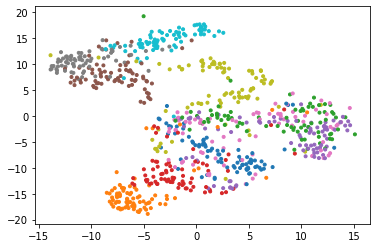

  2%|▏         | 87/4000 [00:00<00:30, 130.41it/s]

Epoch: 100,  Loss:0.19509932398796082


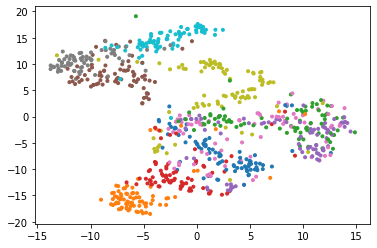

  5%|▍         | 199/4000 [00:01<00:28, 132.48it/s]

Epoch: 200,  Loss:0.19509832561016083


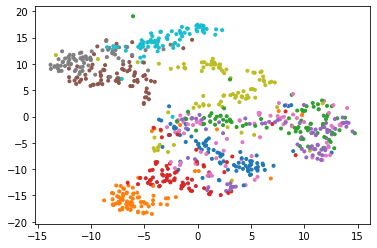

  7%|▋         | 297/4000 [00:02<00:28, 131.54it/s]

Epoch: 300,  Loss:0.195094496011734


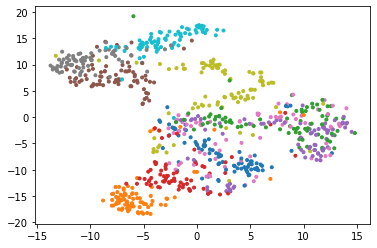

 10%|▉         | 395/4000 [00:03<00:28, 127.92it/s]

Epoch: 400,  Loss:0.1950961947441101


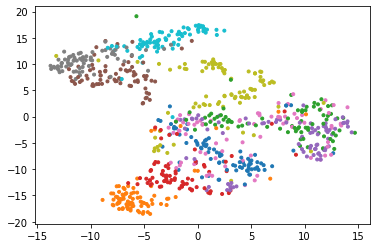

 12%|█▏        | 493/4000 [00:04<00:26, 131.18it/s]

Epoch: 500,  Loss:0.19510430097579956


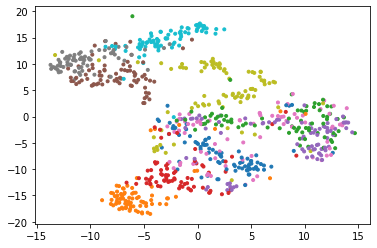

 15%|█▍        | 591/4000 [00:04<00:25, 131.38it/s]

Epoch: 600,  Loss:0.19509510695934296


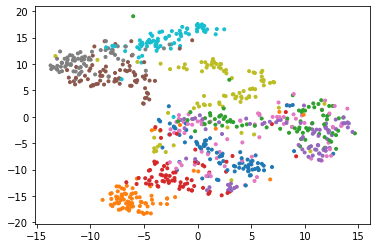

 17%|█▋        | 689/4000 [00:05<00:25, 131.45it/s]

Epoch: 700,  Loss:0.19510677456855774


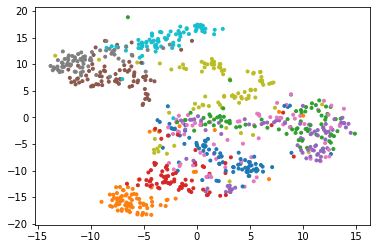

 20%|█▉        | 787/4000 [00:06<00:24, 131.49it/s]

Epoch: 800,  Loss:0.195103257894516


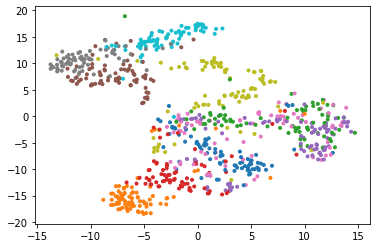

 22%|██▏       | 899/4000 [00:07<00:23, 132.64it/s]

Epoch: 900,  Loss:0.19509996473789215


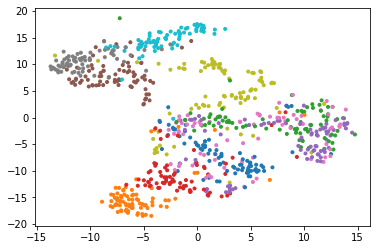

 25%|██▍       | 997/4000 [00:08<00:22, 131.57it/s]

Epoch: 1000,  Loss:0.19510163366794586


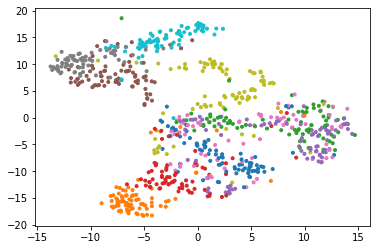

 27%|██▋       | 1095/4000 [00:09<00:22, 131.43it/s]

Epoch: 1100,  Loss:0.19510388374328613


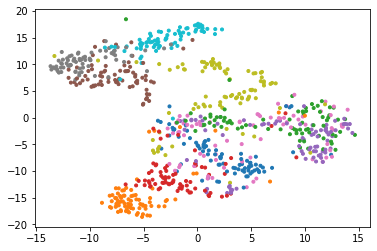

 30%|██▉       | 1193/4000 [00:09<00:21, 131.49it/s]

Epoch: 1200,  Loss:0.1951015293598175


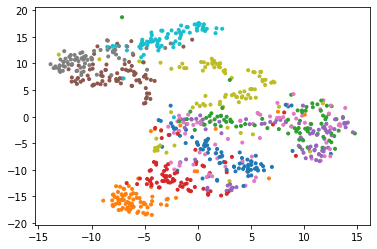

 32%|███▏      | 1291/4000 [00:10<00:20, 131.49it/s]

Epoch: 1300,  Loss:0.19510477781295776


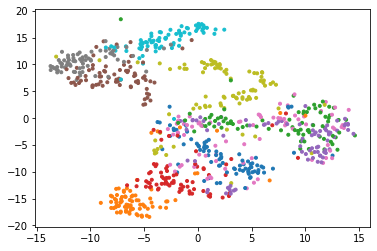

 35%|███▍      | 1389/4000 [00:11<00:19, 131.41it/s]

Epoch: 1400,  Loss:0.19509848952293396


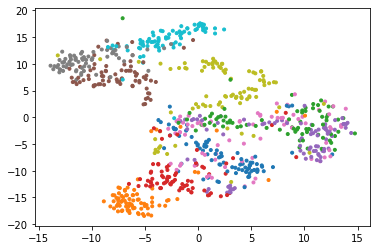

 37%|███▋      | 1487/4000 [00:12<00:19, 131.44it/s]

Epoch: 1500,  Loss:0.19511231780052185


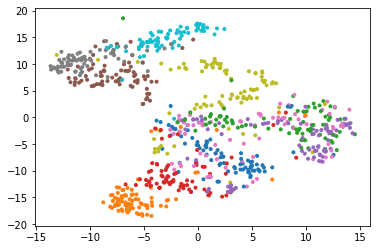

 40%|███▉      | 1599/4000 [00:13<00:18, 132.56it/s]

Epoch: 1600,  Loss:0.19509482383728027


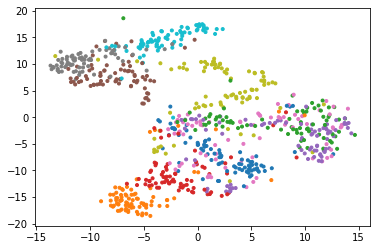

 42%|████▏     | 1697/4000 [00:13<00:17, 131.56it/s]

Epoch: 1700,  Loss:0.1951008439064026


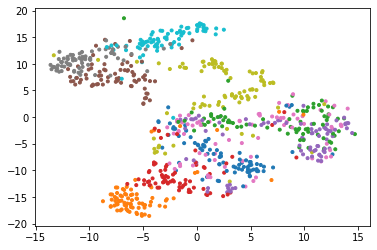

 45%|████▍     | 1794/4000 [00:14<00:16, 130.86it/s]

Epoch: 1800,  Loss:0.1951020359992981


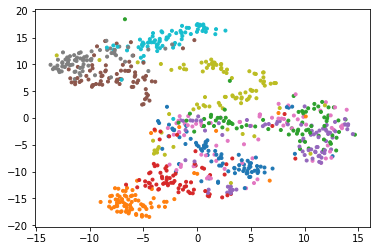

 47%|████▋     | 1892/4000 [00:15<00:16, 131.39it/s]

Epoch: 1900,  Loss:0.19510233402252197


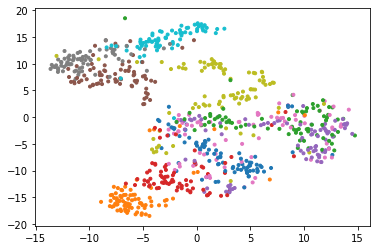

 50%|████▉     | 1990/4000 [00:16<00:15, 131.48it/s]

Epoch: 2000,  Loss:0.19510576128959656


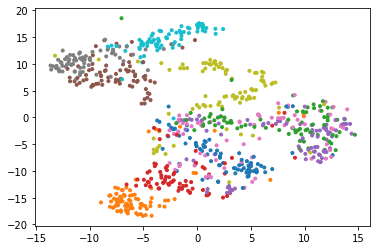

 52%|█████▏    | 2088/4000 [00:17<00:15, 123.82it/s]

Epoch: 2100,  Loss:0.19503313302993774


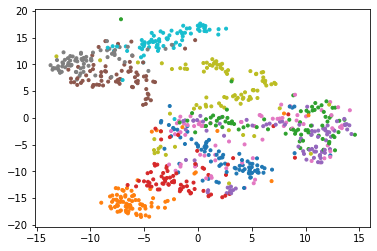

 55%|█████▌    | 2200/4000 [00:18<00:13, 132.19it/s]

Epoch: 2200,  Loss:0.1950352042913437


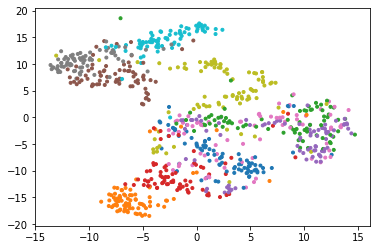

 57%|█████▋    | 2298/4000 [00:19<00:12, 131.57it/s]

Epoch: 2300,  Loss:0.19503635168075562


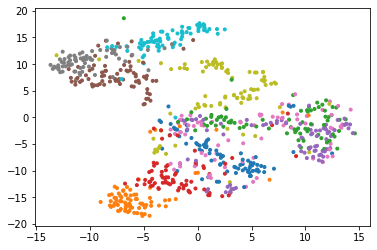

 60%|█████▉    | 2396/4000 [00:19<00:12, 131.51it/s]

Epoch: 2400,  Loss:0.1950322687625885


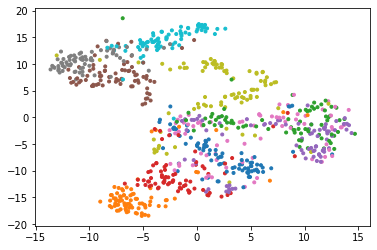

 62%|██████▏   | 2494/4000 [00:20<00:11, 131.48it/s]

Epoch: 2500,  Loss:0.1950414627790451


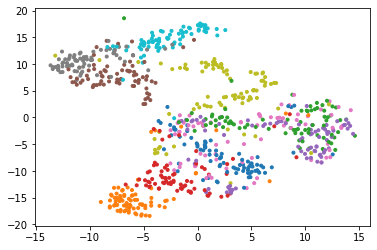

 65%|██████▍   | 2592/4000 [00:21<00:10, 131.44it/s]

Epoch: 2600,  Loss:0.1950368732213974


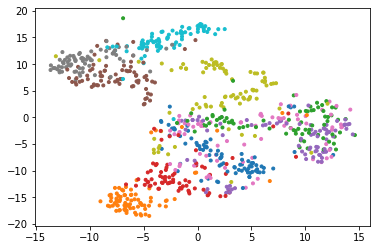

 67%|██████▋   | 2690/4000 [00:22<00:09, 131.44it/s]

Epoch: 2700,  Loss:0.19504240155220032


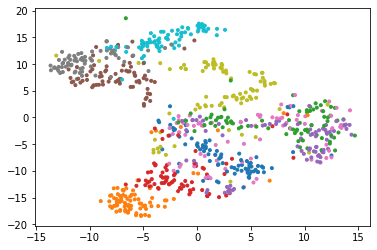

 70%|██████▉   | 2788/4000 [00:23<00:09, 131.43it/s]

Epoch: 2800,  Loss:0.19504648447036743


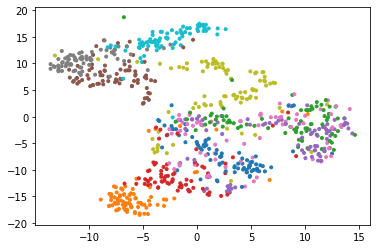

 72%|███████▎  | 2900/4000 [00:24<00:08, 132.70it/s]

Epoch: 2900,  Loss:0.19504526257514954


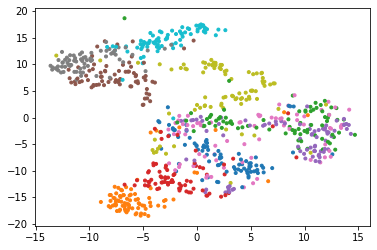

 75%|███████▍  | 2982/4000 [00:24<00:08, 120.64it/s]


KeyboardInterrupt: 

In [451]:
#### Train with Optimizer

train_error = []
for epoch in tqdm(list(range(4000))):
    loss = ump.compute_loss(xx)
    optimizer.zero_grad()
    loss.backward()
    
#     print(ump.y_centers.grad)
#     print(torch.count_nonzero(torch.isnan(ump.y_centers.grad)))
#     print(torch.count_nonzero(torch.isinf(ump.y_centers.grad)))
    ump.y_centers.grad[torch.isnan(ump.y_centers.grad)] = 0
    
    optimizer.step()
    stdm = ump.y_centers.data.std()
    ump.y_centers.data = ump.y_centers.data + \
                (torch.rand_like(ump.y_centers.data)-0.5)*0.01*float(stdm)

    train_error.append(float(loss))
    
    if epoch%100 == 0:
#         print(ump.y_centers.data.std())
        print(f'Epoch: {epoch},  Loss:{float(loss)}')
        plt.scatter(*ump.y_centers.cpu().data.numpy().T, c=yy, marker='.', cmap="tab10")
        plt.show()
#     break

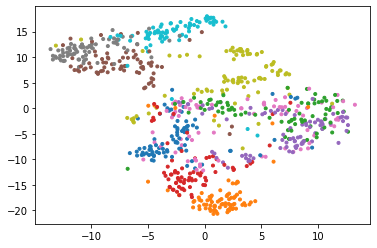

In [441]:
plt.scatter(*ump.y_centers.cpu().data.numpy().T, c=yy, marker='.', cmap="tab10")

## UMAP - from library

In [442]:
import umap

In [443]:
embed = umap.UMAP(n_neighbors=783, n_components=2, min_dist=0.1, spread=1, metric="euclidean")
# embed = umap.UMAP(n_neighbors=784, n_components=2, min_dist=0.1, spread=1,
# #                   target_metric='euclidean',
#                   target_metric='categorical',
#                   target_weight=0.1
#                  )

In [444]:
embedding = embed.fit_transform(xx.data.cpu().numpy())
# embedding = embed.fit_transform(centers, output_cent)

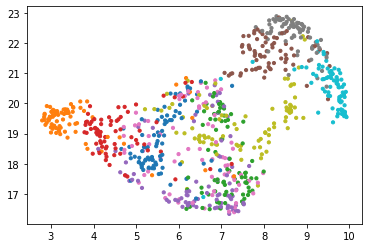

In [445]:
plt.scatter(embedding[:,0], embedding[:, 1], c=yy, s=10, cmap="tab10")

In [446]:
j = 0

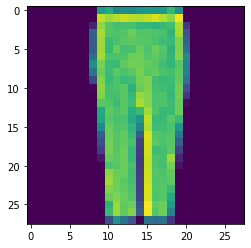

In [448]:
plt.imshow(xx.cpu()[j].reshape(28,28))
j += 1